Modellera MNIST
MNIST är ett standarddataset inom maskininlärning som används för att träna och testa algoritmer för bildigenkänning. Det består av 70 000 gråskalebilder av handskrivna siffror (0–9), där varje bild är 28×28 pixlar.
Del 1 – Skapa en ML-modell (G)
Använd maskininlärning för att modellera MNIST-datan. Du skall utvärdera minst två olika modeller i ditt arbete och göra ett komplett ML-flöde, från början där du laddar in data till slut där du utvärderar den bäst valda modellen på din testdata.

Börjar med att importera bibliotek som behövs samt laddar ner den data som behövs. 

In [ ]:
# Här importerar jag allt som behövs
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
from sklearn.pipeline import Pipeline
import time
from datetime import timedelta 
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import cross_val_predict
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

Jag går vidare med att skapa en funktion som visualiserar Confusion- och Error Matrix, som jag kan anropa när jag önskar.

In [3]:
# Skapar en funktion som visualiserar confusion- och error-matrix
def plot_confusion_and_error_matrices(cm, title_suffix=""):
    
    # Error matrix - kopierar cm och nollställer diagonalen
    em = cm.copy()
    np.fill_diagonal(em, 0)

    # Confusion Matrix
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, cmap="Blues")
    plt.title(f"Confusion Matrix{title_suffix}")
    plt.xlabel("Predikterad siffra")
    plt.ylabel("Sann siffra")
    plt.colorbar()

    threshold_cm = cm.max() / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            color = "white" if cm[i, j] > threshold_cm else "black"
            plt.text(j, i, cm[i, j], ha="center", va="center", color=color)

    plt.xticks(range(10))
    plt.yticks(range(10))
    plt.tight_layout()
    plt.show()

    # Error Matrix
    plt.figure(figsize=(8, 6))
    plt.imshow(em, cmap="Reds")
    plt.title(f"Error Matrix{title_suffix}")
    plt.xlabel("Predikterad siffra")
    plt.ylabel("Sann siffra")
    plt.colorbar()

    threshold_em = em.max() / 2
    for i in range(em.shape[0]):
        for j in range(em.shape[1]):
            color = "white" if em[i, j] > threshold_em else "black"
            plt.text(j, i, em[i, j], ha="center", va="center", color=color)

    plt.xticks(range(10))
    plt.yticks(range(10))
    plt.tight_layout()
    plt.show()

In [ ]:
# hämtar data till modellen och skriver ut info för att undersöka den
mnist = fetch_openml("mnist_784", version=1, cache=True, as_frame=False)
print (mnist.DESCR)

# delar in data i målvaribel och övriga

X = mnist["data"]
y = mnist["target"]

**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  
**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  
**Please cite**:  

The MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  

It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 image b

In [12]:
# Kontrollerar vilka datatyper X och y är
print ("y", type (y))
print ("X", type (X))

y.dtype

y <class 'numpy.ndarray'>
X <class 'numpy.ndarray'>


dtype('O')

Då y verkar tolkas som ett objekt (sträng) så bör den omvandlas till heltal i stället. Det riskerar inget dataläckage eller påverkar modellen i övrigt att justera datatyp. 

In [5]:
# omvandlar från sträng till siffror och skriver ut ny datatyp
y = y.astype(int)
y.dtype


dtype('int64')

Går vidare med att dela in data i träning- och testdata. Jag avsätter ingen del till validering då jag tänk validera med crossvalidation. Denna indelning väljer jag att göra redan här för att kunna gå vidare med min EDA endast med träningsdata, och ingen testdata.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.15, # kör på 85/15 med detta dataset - lite mer till träning, finns ändå mycket kvar för test
    random_state=42,
    stratify=y # säkerställer att alla siffror kommer med i både träning och testdatan
)


Går vidare med EDA för att utforska datat.

In [5]:
print (X_train.shape) # skriver ut antal bilder (observationer) och antal pixlar per bild
print (y_train.shape) # skriver ut antal observationer (bilder) i målvariabeln


(56000, 784)
(56000,)


Går vidare med att se hur en bild (en rad med 784 pixlar) faktiskt ser ut. Här har jag testat att ändra index till olika värden för att visa flera olika siffror och få en uppfattning om hur variationen i de handskrivna siffrorna ser ut.

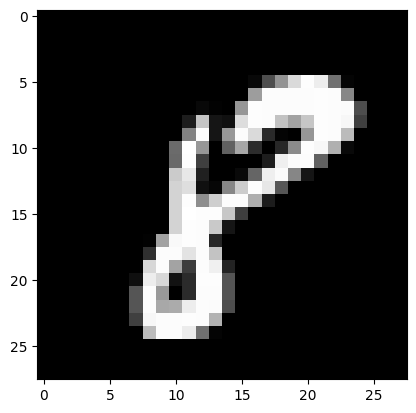

In [ ]:
bild = X_train[5]              # tar ut en bild (en rad), kan ändra siffra i [] för att visa olika bilder
bild_2d = bild.reshape(28, 28) # gör om raden till en 28x28-bild

plt.imshow(bild_2d, cmap="gray")  # visar bilden i gråskala
plt.show()


Ovan utskift visar att det är extremt låg upplösning och till och med jag har svårt att tyda siffran! Det finns därför en risk att detta blir en svår uppgift för en enkel modell och att jag kommer behöva testa mig fram. Nästa steg är att kontrollera klassfördelningen så att varje siffra finns representerad många gången efter uppdelningen i train/test.

In [ ]:
# kontrollerar först att varje siffra finns med och hur många gånger
np.unique_counts(y_train)

UniqueCountsResult(values=array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), counts=array([5522, 6302, 5592, 5713, 5459, 5050, 5501, 5834, 5460, 5567]))

Ovan output säger oss att det finns något fler av ettor, och minst av femmor, men varje siffra är representerad tillräckligt många gånger för att bygga vidare en modell på. Med denna jämna fördelning blir troligtvis accuracy ett bra utvärderingsmått när jag testar modeller.

**MODELLERING**

Jag går vidare och testar standardvarianten av logistisk regressionsmodell, L2 (Ridge), för att se hur väl en enkel modell presterar och kunna jämföra mot andra modeller. Även om jag kommer utvärdera med Accuracy tar jag med F1 också, för att få en uppfattning om modellen är ostabil. Jag inkluderar även hur lång tid det tar att träna modellen, då tid kommer vara en viktig del i mitt modellval.

In [ ]:
# Skapar en pipeline för att skala om pixlar och träna en enkel ML-modell
pipeline_l2 = Pipeline(steps=[
    
    ("scaler", StandardScaler()), # Skalar pixelvärdena (X) så att alla pixlar "väger" lika mycket
    
    
    ("classifier", LogisticRegression(
        max_iter=1000, # Ökar max_iter till 1000 eftersom MNIST har många features (pixlar) och modellen annars riskerar att inte konvergera

    ))
])

# Lägger in starttid
import time
start_time = time.time()

# Tränar och utvärderar modellen med cross-validation på träningsdata
from sklearn.model_selection import cross_val_score, cross_val_predict

y_pred_l2 = cross_val_predict(
    pipeline_l2,
    X_train,
    y_train,
    cv=5
)

# Lägger in stopptid för att skriva ut tiden modellen tar att träna
end_time = time.time ()
execusion_time_l2 = end_time - start_time

f1 = f1_score(y_train, y_pred_l2, average="weighted") # plockar fram f1 för att se hur balaserad modellen är
accuracy_l2 = accuracy_score(y_train, y_pred_l2) # tar fram accuracy för att jämföra med andra modeller
cm_l2 = confusion_matrix(y_train, y_pred_l2) # denna visualiserar jag endast om jag är nöjd med accuracy

print("Accuracy L2:", accuracy_l2)
print("F1_L2:", (f1))
print ("Tid för L2:", execusion_time_l2)



Accuracy L2: 0.9110420168067227
F1_L2: 0.9108772910036663
Tid för L2: 54.65587782859802


Tid: 1 min 15 sek ovan körning. Den logistiska regressionsmodellens standard (L2) uppnådde en genomsnittlig accuracy på cirka 91 % vid 5-fold cross-validation, vilket indikerar att modellen korrekt klassificerar majoriteten av siffrorna och utgör en stabil baseline för vidare modelljämförelser. För att få en bättre överblick i hur modellen presterade går jag vidare och visualiserar ovan med både confusion- och error- matrix.

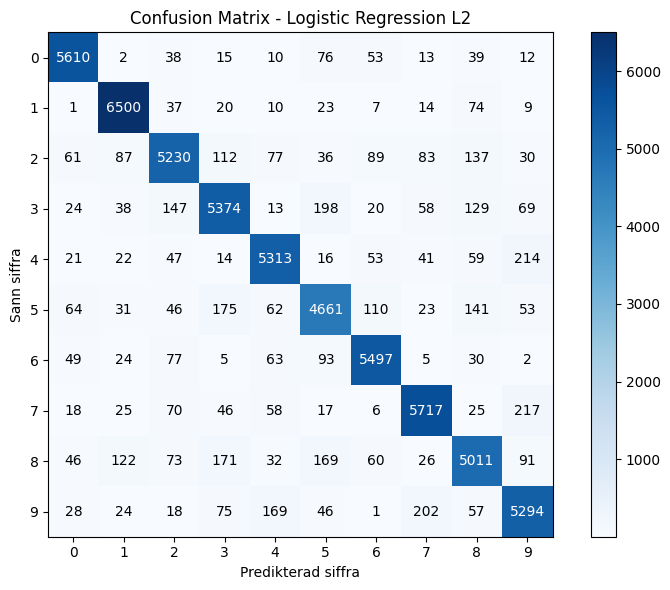

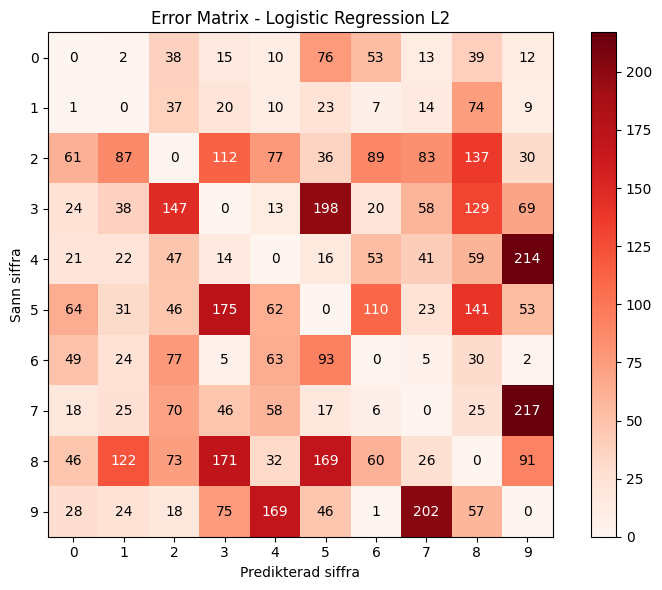

In [12]:
# Visualiserar ovan modell med matrix
plot_confusion_and_error_matrices(cm_l2, " - Logistic Regression L2")

Ovan confusion matrix visar att siffran 5 är den siffra som predikteras korrekt i minst antal fall (4382). Även siffrorna 2 och 8 tillhör de med lägst rätt prediktioner. Kollar man på error matrix ser man att 7:or ofta tolkas som 9:or och att 9:or i sin tur ofta tolkas som 7:or. Även 3:or och 5:or förväxlas tydligt med varandra. Just 8:or och 3:or verkar modellen ha svårast för då de har många fel totalt och dessutom blandas ihop med flera olika siffror. Generellt verkar siffror med liknande rundade former blandas ihop oftare än mer “rakare” siffror.

**L1/Lasso**

L2 presterade bra med accurucy 91%. Jag vill gå vidare och testa en annan logistisk regressions modell, L1, för att se om det är några features som kan tas bort och se om den modellen ger en bättre accucury.

In [ ]:
# Skapar en ny pipeline för L1
pipeline_l1 = Pipeline(steps=[
    
    ("scaler", StandardScaler()), # Skalar pixelvärdena (X) så att alla pixlar "väger" lika mycket 
    ("classifier", LogisticRegression(
        penalty="l1", # ändra till l1_ratio=1 här
        solver="saga",
        max_iter=1000, # Ökar max_iter till 1000 eftersom MNIST har många features (pixlar) och modellen annars riskerar att inte konvergera

    ))
])
# Lägger in starttid
import time
start_time = time.time()

# Kör crossvalidation med 5 folds och skriver ut accuracy för att jämföra med L2
y_pred_l1 = cross_val_predict(
    pipeline_l1,
    X_train,
    y_train,
    cv=5
)
# Lägger in stopptid för att skriva ut tiden modellen tar att träna
end_time = time.time ()
execusion_time_l1 = end_time - start_time

accuracy_l1 = accuracy_score(y_train, y_pred_l1)
f1 = f1_score(y_train, y_pred_l2, average="weighted") # plockar fram f1 för att se hur balaserad modellen är
cm_l1 = confusion_matrix(y_train, y_pred_l1) # denna visualiserar jag endast om jag är nöjd med accuracy

print ("accuracy_l1: ", accuracy_l1) 
print ("accuracy_l2: ", accuracy_l2) # skriver ut även accuracy för l2 för jämförelse
print ("F1_L1:", f1)
print ("Tid att träna L1: ", execusion_time_l1)


c:\Users\trysb\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
c:\Users\trysb\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1160: UserWarning: Inconsistent values: penalty=l1 with l1_ratio=0.0. penalty is deprecated. Please use l1_ratio only.
  warnings.warn(


När jag först försökte köra L1-regularisering (Lasso) med hela datasetet ovan märkte jag att det tog väldigt lång tid och stoppade körningen efter 1 timme. Jag testade därför att köra om koden, denna gång med en reducerad delmängd (10 000 samples) men märkte snabbt att modellen även då är väldigt tung att köra. Trots att datasetet  var nedskalat var körningen fortfarande inte klar efter 304 minuter. Det visar att L1-regularisering, i ett multiclass-problem med många features, är väldigt tung. Därför beslutar jag att det inte är en modell jag vill gå vidare med. 

**RandomForest**

Jag går därför vidare och testar en trädmodell för att se hur den presterar, både i tid och accuracy jämför med tidigare modeller.

In [ ]:
# Skapar pipeline för Random Forest
pipeline_rf = Pipeline(steps=[

    ("classifier", RandomForestClassifier(
        random_state=42,
    ))
])

# Lägger in starttid
start_time = time.time()

# Cross-validation (5 folds)
y_pred_rf = cross_val_predict(
    pipeline_rf,
    X_train,
    y_train,
    cv=5,
)

# Lägger in stopptid för att skriva ut tiden modellen tar att träna
execusion_time_rf = time.time() - start_time

# Skapar mått för utvärdering
accuracy_rf = accuracy_score(y_train, y_pred_rf)
f1 = f1_score(y_train, y_pred_rf, average="weighted") # plockar fram f1 för att se hur balaserad modellen är
cm_rf = confusion_matrix(y_train, y_pred_rf) # denna visualiserar jag endast om jag är nöjd med accuracy

print("Accuracy RandomForest: ", round(accuracy_rf, 4)) # avrundar till 4 decimaler
# väntar med denna -- print ("Accuracy L2: ", round(accuracy_l2, 4)) # skriver ut L2 för jämförelse
print ("F1_RandomForest: ", f1)
print (f"Tid att träna RandomForest: {timedelta(seconds=execusion_time_rf)}")




Accuracy RandomForest:  0.9676
F1_RandomForest:  0.9675911872180719
Tid att träna RandomForest: 0:03:12.945096


Ovan gav mycket bättre accuracy än L2, samt har hög F1 vilket tyder på en balaserad modell. Även tiden är hanterbar. Jag vill testa några till modeller innan jag går vidare med GridSearch för att optimera hyperparametrar. Jag är nyfiken på att se matrix för att se om det är liknande förväxlingar som med min L2 modell och går vidare med visualisering av dessa.

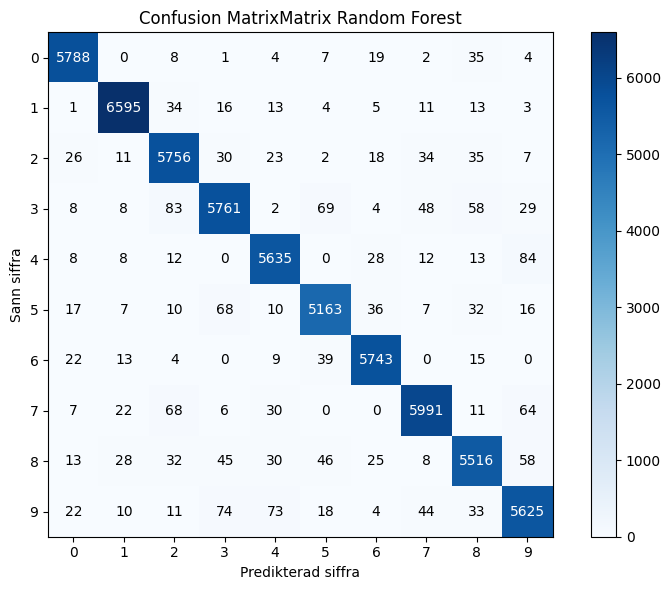

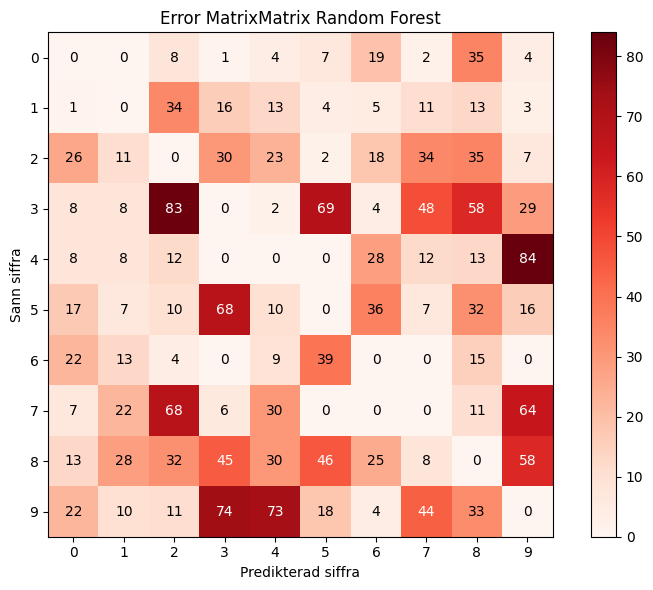

In [14]:
# Visualiserar matrix
plot_confusion_and_error_matrices(cm_rf, title_suffix= "Matrix Random Forest")

Det är fortfarande 5:or som predikteras rätt i minst antal fall, och även 8:or, som för L2. Denna modell verkar dock ha rätt på fler 2:or än L2! Siffra 3 är svårast för Random Forest, med flest antal error - jämfört med L2 där 8:or var svårast. 

**SVC**

Nästa steg blir att jämföra med en SVC-modell. Jag har läst att denna modell kan vara väldigt tung och ta lång tid, så det blir intressant att se hur den presterar både i accuracy och tid.

In [ ]:
# Skapar en pipeline för SVC
svc_pipeline = Pipeline([
    ("scaler", StandardScaler()), # Skalning är viktigt för SVC
    ("classifier", SVC(kernel="rbf")) # Rbf är bäst i detta syfte
])

# Lägger in starttid
start_time = time.time()

# Cross-validation (5 folds)
y_pred_svc = cross_val_predict(
    svc_pipeline,
    X_train,
    y_train,
    cv=5
)

# Lägger in stopptid för att skriva ut tiden modellen tar att träna
end_time = time.time ()
execusion_time_svc = end_time - start_time

accuracy_svc = accuracy_score(y_train, y_pred_svc)
f1_svc = f1_score(y_train, y_pred_svc, average="weighted") # plockar fram f1 för att se hur balaserad modellen är
cm_svc = confusion_matrix(y_train, y_pred_svc) # denna visualiserar jag endast om jag är nöjd med accuracy

print("Accuracy SVC: ", round(accuracy_svc, 4))
# print ("Accurucy L2: ", round(accuracy_l2, 4)) -- denna skriver jag ut sedan men inte just nu
print("F1_SVC:", f1_svc)
print (f"Tid att träna SVC: {timedelta(seconds=execusion_time_svc)}")


Accuracy SVC:  0.9625
F1_SVC: 0.9625603462603468
Tid att träna SVC: 0:38:17.203084


SVC hade också en väldigt bra accuracy, och är en balaserad modell med högt F1-score. Modellen tog dock avsevärt mycket längre tid än RandomForest, som dessutom hade snäppet bättre accuracy. För skojs skull testar jag ovan kod igen, men minskar antal pixlar till 20x20 (kapar hörnen mm), för att se om den går snabbare.

In [16]:
# Skapar en transformer som minskar pixlar till 20x20
class ResizeImages(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_images = X.reshape(-1, 28, 28)
        
        # Tar bort 4 pixlar från varje sida för att behålla mitten av bilden
        X_cropped = X_images[:, 4:24, 4:24]
        
        return X_cropped.reshape(-1, 20*20)


# Ny pipeline med färre pixlar 
svc_pipeline_reduced = Pipeline([
    ("resize", ResizeImages()),   #  Minskar antal pixlar
    ("scaler", StandardScaler()), # Skalning är viktigt för SVC
    ("classifier", SVC(kernel="rbf")) # Rbf är bäst i detta syfte
])

# Lägger in starttid
start_time = time.time()

# Cross-validation (5 folds)
y_pred_svc = cross_val_predict(
    svc_pipeline_reduced,
    X_train,
    y_train,
    cv=5
)
# Lägger in stopptid för att skriva ut tiden modellen tar att träna
end_time = time.time ()
execusion_time_svc = end_time - start_time

accuracy_svc = accuracy_score(y_train, y_pred_svc)
f1 = f1_score(y_train, y_pred_svc, average="weighted") # plockar fram f1 för att se hur balaserad modellen är
cm_svc = confusion_matrix(y_train, y_pred_svc) # denna visualiserar jag endast om jag är nöjd med accuracy

print("Accuracy SVC: ", round(accuracy_svc, 4))
# print ("Accurucy L2: ", round(accuracy_l2, 4))
print("F1_SVC:", f1)
print (f"Tid att träna SVC: {timedelta(seconds=execusion_time_svc)}")


Accuracy SVC:  0.9762
F1_SVC: 0.9761443621652723
Tid att träna SVC: 0:24:51.520688


Jag hade inte förväntat mig att modellen skulle prestera bättre med färre pixlar, jag var mest ute efter att korta ner körtiden. Jag antar att hörnpixlar kanske tillför mest brus, och därför blir modellen mer pricksäker med färre antal pixlar. Nu presterar min SVC bättre än min RandomForest. Dock tar den ca 25 minuter, mot endast 5 minuter för RandomForest. Jag vill därför optimera min RandomForest för att se om den kan komma upp till samma accuracy med bättre hyperparametrar innan jag bestämmer mig. Först vill jag visualisera matrix för SVC.

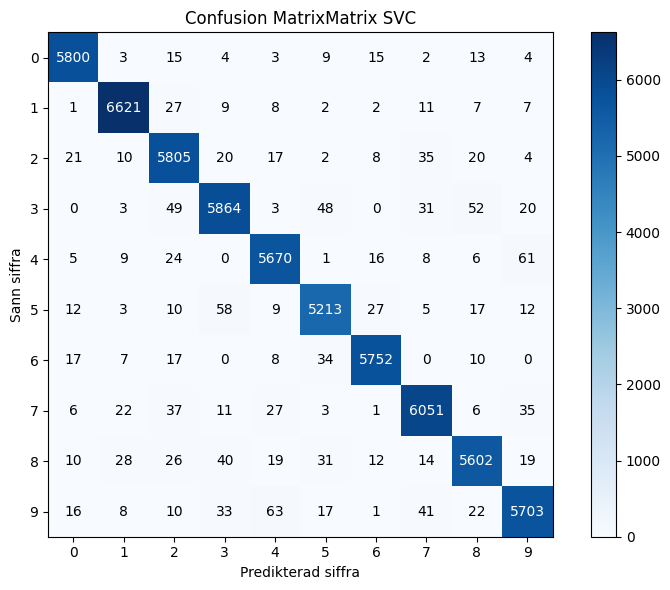

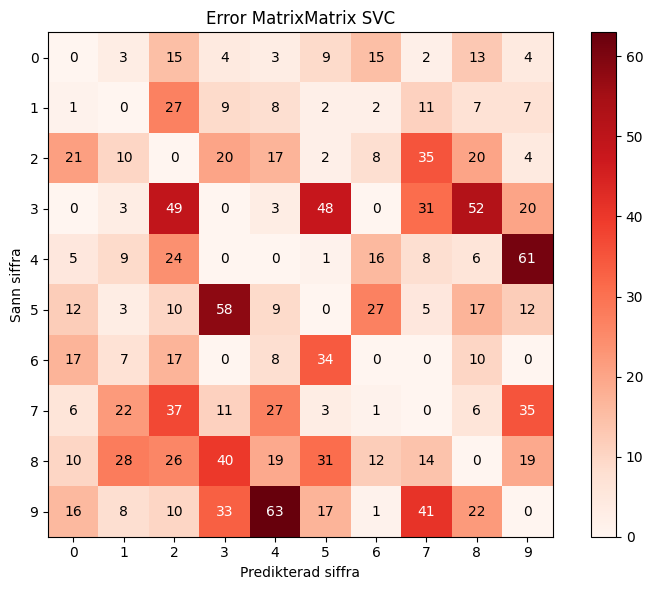

In [17]:
# visualiserar matrix för ovan modell
plot_confusion_and_error_matrices (cm_svc, title_suffix= "Matrix SVC")

SVC har färre antal fel på alla siffror! Men det är fortfarande 3:or, 9:or och 8:or som är i topp 3 bland flest antal fel, oavsett vilken modell man tittar på. Så man kan anta är det dessa kommer vara svåra för appen att prediktera - oavsett modellval.

**Gradient Boosting** 

Innan jag bestämmer modell, och ev optimerar hyperparametrar så vill jag testa Gradient Boosting också. Gradient Boosting bygger sina träd ett i taget där varje nytt träd försöker rätta till misstagen från det förra. Förhoppningen är att det kan minska några av de kvarvarande felklassificeringarna och kanske ge en liten extra förbättring i accuracy.

In [ ]:
# Denna del la jag in i efterhand då det tog för lång tid att köra med hela datasetet
X_small = X_train[:10000]
y_small = y_train[:10000]

# OPTIMERAD Gradient Boosting för att korta ner körtid för ett snabbtest
gb = GradientBoostingClassifier(
    n_estimators=50,        # Minskar från 100
    max_depth=5,            # Ökar från 3 (snabbare konvergens)
    learning_rate=0.1,
    subsample=0.8,          # Sampling gör det mycket snabbare
    random_state=42,
)


# Kör cross-validation (3 folds för att hålla tiden nere i snabbtest)
y_pred_gb = cross_val_predict(
    gb,
    X_small,
    y_small,
    cv=5,
    verbose=2  # Visa CV progress också
)

# Accuracy
accuracy_gb = accuracy_score(y_small, y_pred_gb)
print("Accuracy GradientBoosting (subset): ", round(accuracy_gb, 4))


      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.7172           0.5261            3.52m
         2           1.4394           0.2986            3.39m
         3           1.2308           0.2343            3.38m
         4           1.0719           0.1571            3.32m
         5           0.9436           0.1035            3.28m
         6           0.8449           0.1231            3.20m
         7           0.7524           0.0680            3.13m
         8           0.6851           0.0992            3.08m
         9           0.6145           0.0684            3.00m
        10           0.5570           0.0754            2.92m
        20           0.2298           0.0075            2.17m
        30           0.1227           0.0175            1.45m
        40           0.0726           0.0061           43.64s
        50           0.0472           0.0025            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
      

AttributeError: 'Parallel' object has no attribute '_pre_dispatch_amount'

Gradient Boosting tog alldeles för lång tid. Först testade jag med hela datasetet, men fick avbryta efter ca 3 timmar.
Jag körde då ovan kod (mindre datamängd) med defualt värden men avbröt efter ca 1 timme pga att det också tog för lång tid. Jag läste att det är bättre att justera parametern 'subsample' för att snabba upp tiden och justerade därför min kod och körde igen - och då tog den 20 min. Men även om det är ett mindre dataset bedömmer jag inte det värt att optimera vidare då Accuracy hamnade runt 92%. Då är fortfarande ForestTree och SVC med ~97% bättre, både mer träffsäker och snabbare. Jag kommer därför inte testa vidare för att optimera Gradient Boosting.

**GridSearch**

Nu går jag vidare och ser om jag kan optimera min RandomForest med GridSearch eftersom att RandomForest har presterat nästan på samma nivå som SVC, men mycket snabbare. Jag börjar smått för att se hur lång tid det tar. Jag vill testa att öka antalet träd och hur djupt den går då det bör påverka mest.

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from datetime import timedelta
import time

# Modell
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

# Liten grid (vill ha för många parametrar för rimlig körtid)
param_grid = {
    "n_estimators": [200, 500],
    "max_depth": [None, 30, 50],
}


# GridSearch med 5-fold CV
grid = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring="accuracy",
    verbose=2 # jag vill följa progress/tid
)

# Lägger in starttid
start_time = time.time()

# Tränar modellen
grid.fit(X_train, y_train)

#Lägger in stopptid för att skriva ut tiden modellen tar att träna
execusion_time = time.time() - start_time

# Spara bästa parametrar för att träna om modellen med
best_params_rf = grid.best_params_

print("Bästa accuracy RandomForest_grid:", round(grid.best_score_, 4))
print("Bästa parametrar:", grid.best_params_)
print(f"Tid för GridSearch: {timedelta(seconds=execusion_time)}")
print ("Accuracy RandomForest, utan GridSearch: ", round(accuracy_rf, 4))


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END ...................max_depth=None, n_estimators=200; total time=   9.6s
[CV] END ...................max_depth=None, n_estimators=200; total time=   9.4s
[CV] END ...................max_depth=None, n_estimators=200; total time=   9.8s
[CV] END ...................max_depth=None, n_estimators=200; total time=   8.9s
[CV] END ...................max_depth=None, n_estimators=200; total time=  30.8s
[CV] END ...................max_depth=None, n_estimators=500; total time= 3.2min
[CV] END ...................max_depth=None, n_estimators=500; total time= 1.5min
[CV] END ...................max_depth=None, n_estimators=500; total time= 3.2min
[CV] END ...................max_depth=None, n_estimators=500; total time= 2.9min
[CV] END ...................max_depth=None, n_estimators=500; total time=  28.2s
[CV] END .....................max_depth=30, n_estimators=200; total time=  13.8s
[CV] END .....................max_depth=30, n_est

Ovan GridSearch gav en knappt märkbar förbättring, men ändå en förbättring. Eftersom att den visade att n_estimators bästa parameter är 500 träd så misstänker jag att det kommer påverka tiden det tar att träna modellen negativt. Då accuracy är bättre med SVC, och tiden förmodligen inte kommer skilja sig åt avsevärt mycket väljer jag att stoppa förbättringen av min ForestTree här.

**Slutgiltigt test**

Efter att ha testat flera modeller bedömer jag att SVC är bäst lämpad för syftet (en Streamlit-app som klassificerar nya indata). Samtliga modeller har utmaningar, men SVC ger högst träffsäkerhet i mina tester. Träningstiden är något längre, men fortfarande rimlig. Under utvärderingen använde jag cross-validation; när jag tränar om den valda modellen på all träningsdata utan CV bör träningen gå snabbare (ungefär proportionellt mot antalet folds). Dessutom är filstorleken för SVC-modellen mindre än för den bästa RandomForest-modellen med 500 träd, vilket ger SVC ytterligare en fördel då en mindre modell lämpar sig bättre för användning i en app. Nästa steg är därför att låsa valet (SVC med 20×20 pixlar), träna om på hela träningsmängden och utvärdera en sista gång på den orörda testdatan.

In [19]:
# Samma inställningar som bästa pipeline för tidigare SVC
svc_pipeline_final = Pipeline([
    ("resize", ResizeImages()),
    ("scaler", StandardScaler()),
    ("classifier", SVC(kernel="rbf"))
])

#Slutgiltigt test: träna på train, testa på orörd test
start_time = time.time()

svc_pipeline_final.fit(X_train, y_train)
y_pred_svc_final = svc_pipeline_final.predict(X_test)

end_time = time.time()
execution_time = end_time - start_time

accuracy_svc_final = accuracy_score(y_test, y_pred_svc_final)
f1_svc_final = f1_score(y_test, y_pred_svc_final, average="weighted")
cm_svc_final = confusion_matrix(y_test, y_pred_svc_final)

print("Final test accuracy (SVC 20x20):", round(accuracy_svc_final, 4))
print("Final test F1 (weighted):", (f1_svc_final))
print(f"Tid (träning + prediktion): {timedelta(seconds=execution_time)}")


Final test accuracy (SVC 20x20): 0.9786
Final test F1 (weighted): 0.9785621153157482
Tid (träning + prediktion): 0:27:35.675053


Ovan mått visar att accuracy blev marignellt bättre med den slutgiltiga träningen, men inte oroväckande på något sätt. Ett högt F1 visar också att det är en stabil modell. Träningen tog mycket längre tid än vad jag räknat med, då jag trodde att det skulle gå snabbare utan crossvalidation. Den tränar dock på mer data nu vilket kan påverka tiden, samt att jag hade mycket annat igång på min dator när jag körde koden - vilket såklart påverkar. Jag är ändå nöjd med mitt resultat och kommer använda denna modell till min app. Jag vill se matrix även för min slutgiltiga modell, för att få en uppfattning om vilka siffror appen får svårast att prediktera, och visualiserar det nedan.

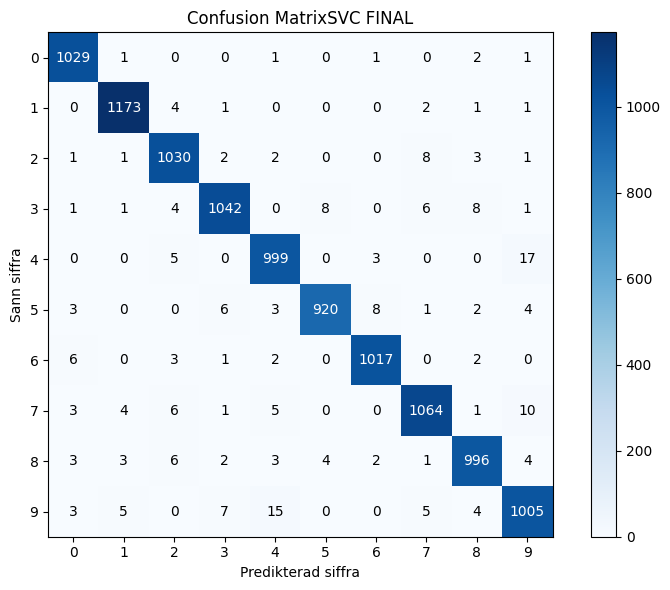

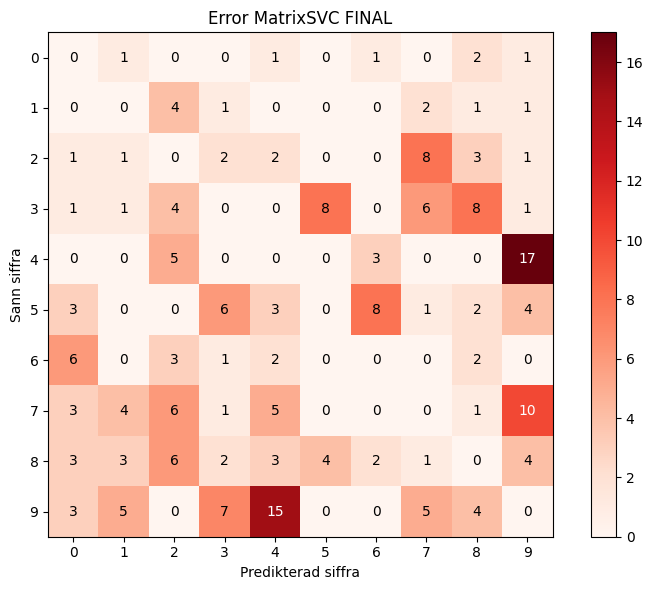

In [20]:
# Kör funktionen med matrix
plot_confusion_and_error_matrices(cm_svc_final, title_suffix= "SVC FINAL")